# Testing Transformer performance on CIFAR10 challenge according to different channel size
Trying to make the Encoder_MultiheadedAttention.py work for the CIFAR 10 challenge. 


In [25]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import math

#from Encoder_MultiheadedAttention import Encoder

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


Files already downloaded and verified
Files already downloaded and verified


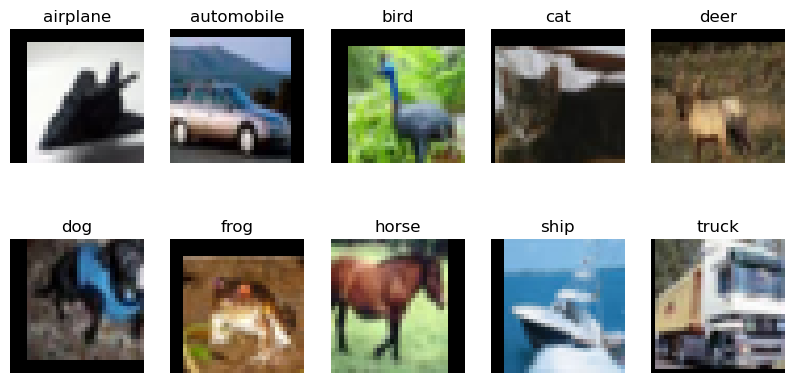

In [26]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

batch_size = 128

# Download and load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create imbalanced traindataset
num_samples_per_class = {k:(k+1)*500 for k in range(10)}
class_to_indices = {cls: np.where(np.array(trainset.targets) == cls)[0] for cls in range(10)}
imbalanced_indices = []
for cls, count in num_samples_per_class.items():
    indices = class_to_indices[cls][:count]  # Select the first `count` samples
    imbalanced_indices.extend(indices)
imbalanced_trainset = Subset(trainset, imbalanced_indices)

trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

# get one image from each class
images = []
for i in range(10):
    for image, label in trainset:
        if label == i:
            images.append(image)
            break

# plot the images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()

In [27]:
def validate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #print("Output: ", outputs[12])
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            #print("Total: ", total)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, trainloader, testloader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    acc_init = validate(model, testloader, device)
    print(f"Accuracy before Training: {acc_init}")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(trainloader): 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            preds = model(inputs)
            
            
            loss = criterion(preds, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, loss: {running_loss/len(trainloader)}")
        train_accuracy = validate(model, trainloader, device)
        print(f"Accuracy on train set: {train_accuracy}")
        accuracy = validate(model, testloader, device)
        print(f"Accuracy on test set: {accuracy}")

In [ ]:
class Attention(nn.Module): 
    def __init__(self, dim_1, dim_2): 
        super(Attention, self).__init__()
        self.K = nn.Linear(dim_1, dim_2, bias=False)
        self.Q = nn.Linear(dim_1, dim_2, bias=False)
        self.V = nn.Linear(dim_1, dim_2, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x): 
        #print("X: ", x.size())
        scores = self.K(x) @ self.Q(x).transpose(-2, -1)
        #print("scores: ", scores.size())
        att_weight = self.softmax(scores / np.sqrt(x.shape[-1]))
        #print("att_weight", att_weight.size())
        out = att_weight @ self.V(x)
        #print("out weight: ", out.size())
        return out

class MultiHeadAttention(nn.Module): 
    def __init__(self, dim_1, dim_2, num_heads): 
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList(Attention(dim_1, dim_2) for _ in range(num_heads))
        self.Z = nn.Linear(num_heads * dim_2, dim_1)

    def forward(self, x): 
        #print(x.size())
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        #print(out.size())
        return self.Z(out)
    
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, max_len=32):
        super(PositionalEncoding2D, self).__init__()
        pe = torch.zeros(d_model, max_len, max_len)
        pos_x = torch.arange(max_len).unsqueeze(1)
        pos_y = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe[:, :, 0::2] = torch.sin(pos_x * div_term).unsqueeze(1)
        pe[:, :, 1::2] = torch.cos(pos_y * div_term).unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :x.size(2), :x.size(3)]
    
class EncoderLayer(nn.Module):
    def __init__(self, dim_1, head_size, num_heads, ff_size): 
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(dim_1, head_size, num_heads)
        self.layer_norm = nn.LayerNorm(dim_1)
        self.dropout = nn.Dropout(p=0.2)
        self.ff = nn.Sequential(
            nn.Linear(dim_1, ff_size), 
            nn.GELU(), 
            nn.Linear(ff_size, dim_1)
        )  
    
    def forward(self, x): 
        out = x + self.mha(x)
        #out = self.dropout(out)
        out = self.layer_norm(out)
        temp = out
        out = temp + self.ff(out)
        out = self.layer_norm(out)
        return out

class Encoder(nn.Module): 
    def __init__(self, dim, head_size, num_heads, ff_size, num_encoders, num_classes): 
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList(EncoderLayer(dim_1=dim, head_size=head_size, num_heads=num_heads, ff_size=ff_size) for _ in range(num_encoders))
        #self.pe = PositionalEncoding2D(dim, max_len=32)
        self.linear = nn.Linear(dim, num_classes)
    
    def forward(self, x): 
        #x = x + self.pe(x)
        for layer in self.layers: 
            x = layer(x)
        #print("X size: ", x.size())
        x = x.mean(dim=1) 
        #x = x.mean(dim=1)
        #print(x.size())
        out = self.linear(x)
        #print("Out size: ", out.size())
        return self.linear(x)


In [ ]:
# Get one image from the dataset

image, label = trainset[0]
# Patch size P 
P = 4
C = image.size(dim=0)
H = image.size(dim=1)
W = image.size(dim=2)
N = H*W / (P ** 2)

# ResOfImage = N x (P**2*C)
# Flatten the image
flattened_image = image.unfold(1, P, P).unfold(2, P, P)
flattened_image = flattened_image.contiguous().view(C, -1, P * P).permute(1, 0, 2).contiguous().view(-1, P * P * C)
print("Not Flattened Image: ", image.size())
print("Flattened Image: ", flattened_image.size())
#
K = nn.Linear(H, W, bias=False)
Q = nn.Linear(H, W, bias=False)
V = nn.Linear(H, W, bias=False)
softmax = nn.Softmax(dim=-1)

scores = K(image) @ Q(image)
att_weight = softmax(scores / np.sqrt(image.shape[-1]))
out = att_weight @ V(image)


channel, x, y = out.size()
pos_x = torch.arange(x, device=out.device)
pos_y = torch.arange(y, device=out.device)
# Einfach erstmal zwei for schleifen die über alle channel alles iterieren? 

div_term_x = torch.exp(torch.arange(0, x, 2).float() * (-math.log(10000.0) / x))
div_term_y = torch.exp(torch.arange(0, y, 2).float() * (-math.log(10000.0) / y))

sin_inp_x = torch.sin(torch.einsum("i,j->ij", pos_x, div_term_x))
sin_inp_y = torch.cos(torch.einsum("i,j->ij", pos_y, div_term_y))

pe = torch.zeros(channel, x, y)

print(sin_inp_x.size())
print(sin_inp_y.size())

pe[:, :, 0::2 ] = torch.sin(sin_inp_x)
pe[:, :, 1::2] = torch.cos(sin_inp_y)



Not Flattened Image:  torch.Size([3, 32, 32])
Flattened Image:  torch.Size([64, 48])
torch.Size([32, 16])
torch.Size([32, 16])


In [44]:
# Funktion zum Flatten der Bilder
def flatten_images(dataset, P):
    flattened_images = []
    for image, label in dataset:
        C, H, W = image.size()
        flattened_image = image.unfold(1, P, P).unfold(2, P, P)
        flattened_image = flattened_image.contiguous().view(C, -1, P * P).permute(1, 0, 2).contiguous().view(-1, P * P * C)
        flattened_images.append((flattened_image, label))
    return flattened_images

# Patch-Größe P
P = 4

# Flatten der Trainings- und Testbilder
flattened_trainset = flatten_images(imbalanced_trainset, P)
flattened_testset = flatten_images(testset, P)
trainloader = torch.utils.data.DataLoader(flattened_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(flattened_testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [45]:
num_heads = 12  # Example number of heads
image, label = flattened_trainset[0]
dim_1 = image.size(dim=0)
dim_2 = image.size(dim=1)
print(dim_1, dim_2)
# Initialize the Encoder model with the calculated dimensions
model = Encoder(dim=dim_2, head_size=dim_1, num_heads=num_heads, ff_size=1024, num_encoders=10, num_classes=10)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

train(model, trainloader, testloader, criterion, optimizer, num_epochs=100, device=device)

64 48
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torch.Size([128, 48])
torc

  0%|          | 0/215 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
  0%|          | 0/215 [00:04<?, ?it/s]    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/__init__.py", line 2665, in <module>
    _import_device_backends()
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/__init__.py", line 2632, in _import_device_backends
    backend_extensions = entry_points(group=group_name)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/importlib/metadata/__init__.py", line 912, in entry_points
    return EntryPoints(eps).select(**params)
          

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')


In [ ]:
model = Encoder(dim=dim_1, head_size=dim_2, num_heads=num_heads, ff_size=1024, num_encoders=10, num_classes=10).to(device)
model.load_state_dict(torch.load('model.pth', weights_only=True))
model.eval()
validate(model, testloader, device)

0.5436